# Solving GCD = 10 by Clustering

This notebook shows how to solve a special case of the February TPS by clustering. It focuses only on this special case and merges the output into [dmitryuarov](https://www.kaggle.com/dmitryuarov)'s [top-scoring notebook](https://www.kaggle.com/dmitryuarov/forest-of-extra-trees-0-9895-up-to-4th-place).

The main point of the notebook is: Because training and test distributions differ in the February TPS, supervised learning (e.g. ExtraTreesClassifier) doesn't find the optimum decision boundaries. By clustering the test data, we can move the decision boundaries to where they belong.

# Preparation

We start by reading the data and adding two columns
- `target_num` (target label encoded with an integer from 0 through 9)
- `gcd` (gcd of all integer features, which is 1, 10, 1000 or 10000 as described in the [EDA](https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gc

from math import factorial
from scipy.stats import mode

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering


In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv')

elements = [e for e in train_df.columns if e != 'row_id' and e != 'target']

# Convert the 10 bacteria names to the integers 0 .. 9
le = LabelEncoder()
train_df['target_num'] = le.fit_transform(train_df.target)


In [3]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
test_i = pd.DataFrame({col: ((test_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})

def gcd_of_all(df_i):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train_df['gcd'] = gcd_of_all(train_i)
test_df['gcd'] = gcd_of_all(test_i)


# Analysis of the top-scoring public submission


In [4]:
# Read @dmitryuarov's notebook
top_submission = pd.read_csv('../input/forest-of-extra-trees-0-9895-up-to-4th-place/submission__blend.csv')


As a first step of the analysis, we select the samples with gcd = 10 from the training data and from the public submission. We then plot a 2d projection of the data, colored by the target label (for the training data, this is the ground truth; for the public submission, this is the prediction). We see
1. Training data and test data look similar (which is good).
2. The samples of every bacterium (i.e. of every color) are arranged in eight clusters which lie on a ray emanating from the origin. With 10 bacteria and 8 clusters per bacterium, this gives a total of 80 clusters.

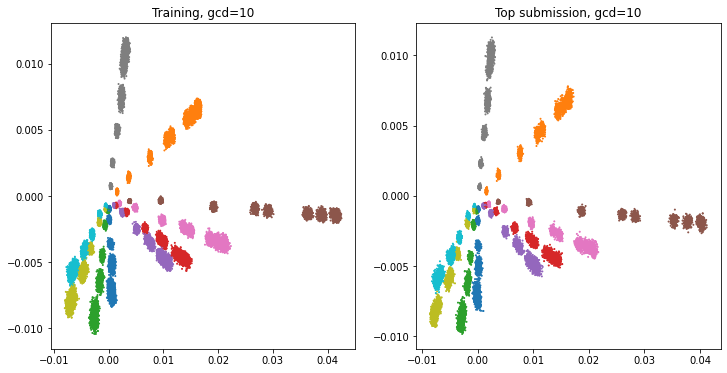

In [5]:
def pca_gcd10_full(df, target, title):
    """Plot a 2d projection of all points of df with gcd = 10, colored by target"""
    subset = df[df.gcd == 10]
    pred_subset = le.transform(target)[df.gcd == 10]
    # Compute the PCA
    pca3 = TruncatedSVD(n_components=10, random_state=1)
    pca3.fit(subset[elements])

    # Transform the data so that the components can be analyzed
    Xt_tr3 = pca3.transform(subset[elements])

    # Plot a scattergram, projected to two PCA components
    d0, d1 = 1, 2
    plt.scatter(Xt_tr3[:,d0], Xt_tr3[:,d1], c=pred_subset, cmap='tab10', s=1)
    plt.title(title)
    
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pca_gcd10_full(train_df, train_df.target, 'Training, gcd=10')
plt.subplot(1, 2, 2)
pca_gcd10_full(test_df, top_submission.target, 'Top submission, gcd=10')
plt.show()

The two diagrams above suggest that the test data has been accurately classified - except maybe the innermost part (near the origin), which is not clearly visible.

We now zoom in on the innermost cluster of bacteria 3 and 4.

In [6]:
def pca_gcd10_selection(df, target, title, clustering, innermost):
    """Plot a 2d projection of certain points of df, colored by target
    or by a clustering, and add the new clustering labels to df.
    
    We select the two innermost clusters with gcd = 10 of bacteria 3 and 4"""
    # Get the subset
    subset = df[df.gcd == 10].copy()
    subset['radius'] = np.sqrt(np.square(subset[elements]).sum(axis=1))
    subset['pred'] = le.transform(target)[df.gcd == 10]
    mean_radius = subset.radius.groupby(subset.pred).mean()
    mean_radius.name = 'mean_radius'
    subset = subset.merge(mean_radius, left_on='pred', right_index=True).sort_index()
    if innermost:
        selection = ((subset.radius < subset.mean_radius * 0.388) &
                     subset.pred.isin([3, 4]))
    else:
        selection = ((subset.radius >= subset.mean_radius * 0.388) &
                     (subset.radius < subset.mean_radius * 0.64) & 
                     subset.pred.isin([3, 4]))
    subset = subset[selection]
    #print(subset.groupby(subset.pred).count()['row_id'])

    if clustering:
        # Cluster the data into two clusters
        #km = KMeans(n_clusters=2, random_state=1)
        km = AgglomerativeClustering(n_clusters=2)
        km.fit(subset[elements])
        # For every cluster, predict the most frequent label for all cluster members
        new_pred = subset.pred.groupby(km.labels_).transform(lambda s: [mode(s)[0][0]] * len(s))
        print(f"Relabeled {(new_pred != subset.pred).sum()} samples")

    # Compute the PCA
    pca3 = TruncatedSVD(n_components=10, random_state=1)
    pca3.fit(subset[elements])

    # Transform the data so that the components can be analyzed
    Xt_tr3 = pca3.transform(subset[elements])

    # Plot a scattergram, projected to two PCA components
    d0, d1 = 2, 1
    plt.scatter(Xt_tr3[:,d0], Xt_tr3[:,d1],
                cmap=ListedColormap(plt.get_cmap('tab10').colors[3:5]),
                c=(new_pred if clustering else subset.pred),
                s=25)
    plt.title(title)
    if clustering:
        selected = pd.Series(False, index=df.index)
        selected.loc[df.gcd == 10] = selection
        df.loc[selected, 'new_pred'] = new_pred

The next four diagrams show:
- Top left: In the training data, the samples form a red cluster (bacterium 3) and a violet cluster (bacterium 4).
- Top right: In the training data, the clustering algorithm clusters the samples into bacterium 3 and bacterium 4 with high accuracy.
- Bottom left: In the test data, the labels predicted by the current top submission **do not follow the cluster boundaries**.
- Bottom right: If we relabel the test data with the output of the clustering algorithm, the labels look better (more similar to the training labels) than the current top submission.


Relabeled 1 samples


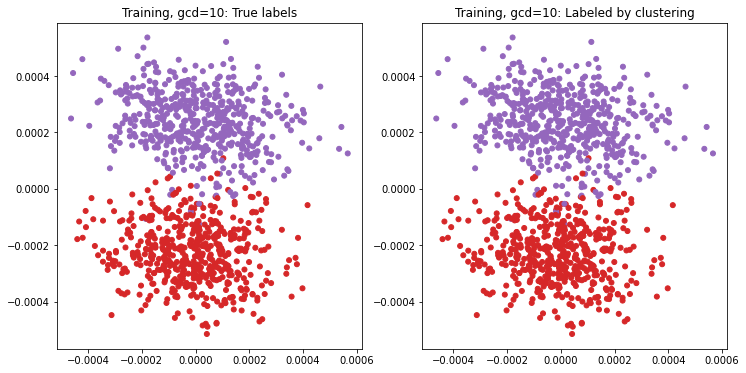

Relabeled 67 samples


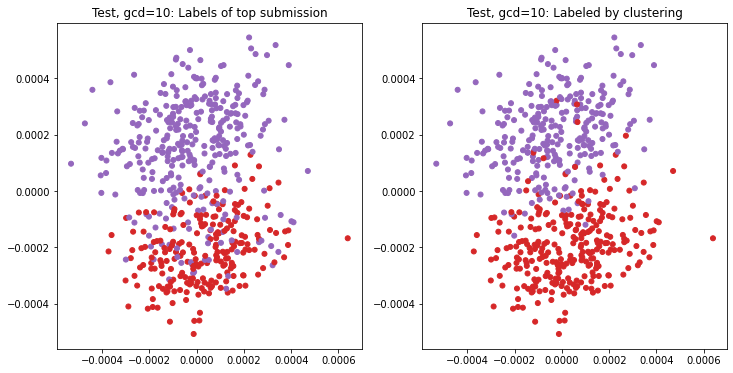

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pca_gcd10_selection(train_df, train_df.target, 
                    'Training, gcd=10: True labels',
                    clustering=False, innermost=True)
plt.subplot(1, 2, 2)
pca_gcd10_selection(train_df, train_df.target,
                    'Training, gcd=10: Labeled by clustering',
                    clustering=True, innermost=True)
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pca_gcd10_selection(test_df, top_submission.target, 
                    'Test, gcd=10: Labels of top submission',
                    clustering=False, innermost=True)
plt.subplot(1, 2, 2)
pca_gcd10_selection(test_df, top_submission.target, 
                    'Test, gcd=10: Labeled by clustering',
                    clustering=True, innermost=True)
plt.show()

The diagrams above suggest that we can improve the top submission if we replace its predictions by the cluster labels.

Let's try the same operation with the second-to-innermost clusters:

Relabeled 0 samples


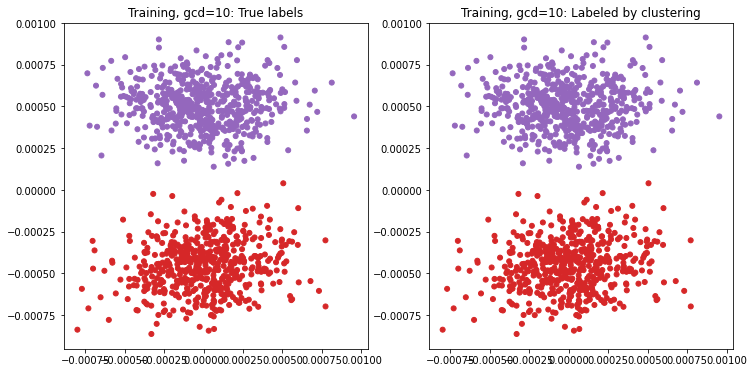

Relabeled 5 samples


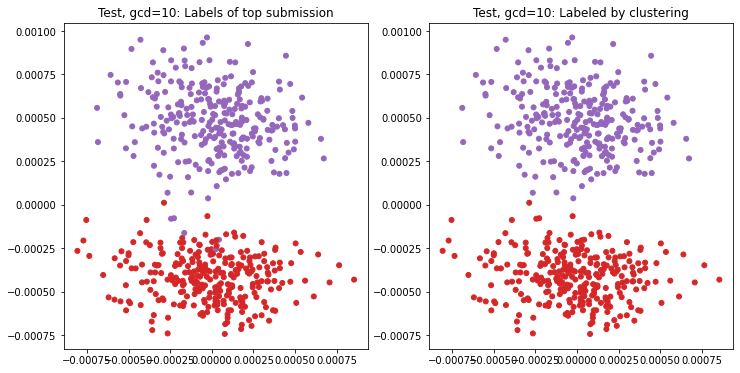

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pca_gcd10_selection(train_df, train_df.target,
                    'Training, gcd=10: True labels', 
                    clustering=False, innermost=False)
plt.subplot(1, 2, 2)
pca_gcd10_selection(train_df, train_df.target, 
                    'Training, gcd=10: Labeled by clustering',
                    clustering=True, innermost=False)
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pca_gcd10_selection(test_df, top_submission.target,
                    'Test, gcd=10: Labels of top submission',
                    clustering=False, innermost=False)
plt.subplot(1, 2, 2)
pca_gcd10_selection(test_df, top_submission.target,
                    'Test, gcd=10: Labeled by clustering',
                    clustering=True, innermost=False)
plt.show()

# Submission

To finish today's work, we relabel 68 predictions and submit the result.


In [9]:
top_submission['new_pred'] = top_submission.target
top_submission.loc[~test_df.new_pred.isna(), 'new_pred'] = le.inverse_transform(test_df.new_pred.dropna().astype(int))

print(f"Relabeled predictions: {(top_submission.new_pred != top_submission.target).sum()}")
submission = top_submission[['row_id', 'new_pred']].rename(columns={'new_pred': 'target'})
submission.to_csv('submission.csv', index=False)
submission

Relabeled predictions: 72


,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
...,...,...
99995,299995,Streptococcus_pneumoniae
99996,299996,Bacteroides_fragilis
99997,299997,Bacteroides_fragilis
99998,299998,Bacteroides_fragilis


Future work: It is plausible that a similar method will improve the predictions for gcd=1000 and gcd=10000 as well.